<a href="https://colab.research.google.com/github/sydneysimmons/bottle-image-classification-project/blob/main/TF_CNN_ResMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/sydneysimmons/bottle-image-classification-project.git
data_dir = "/content/bottle-image-classification-project/data/Bottle Images"

Cloning into 'bottle-image-classification-project'...
remote: Enumerating objects: 40046, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 40046 (delta 7), reused 12 (delta 2), pack-reused 40016
Receiving objects: 100% (40046/40046), 1.25 GiB | 22.39 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (40011/40011), done.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00002168.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00002575.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00002174.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00004136.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00003676.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00003373.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00004997.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00003122.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00000012.jpg
/content/bottle-image-classification-project/data/Bottle Images/Beer Bottles/00002643.jpg
/content/bottle-image-classification-project/data

In [4]:
data_dir

'/content/bottle-image-classification-project/data/Bottle Images'

In [5]:
import tensorflow as tf
import pandas as pd
import cv2, os, shutil, math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
import matplotlib.pyplot as plt

In [8]:
!find . -name ".DS_Store" -delete

In [9]:
sdir = '/content/bottle-image-classification-project/data/Bottle Images/'

def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    return train_df, test_df, valid_df

train_df, test_df, valid_df = make_dataframes(sdir=sdir)

Wine Bottle            : 100%|█████████████████████████████████████████| 5000/5000 [00:06<00:00, 782.48file/s]


number of classes in processed dataset=  5
the maximum files in any class in train_df is  4000   the minimum files in any class in train_df is  4000


In [10]:
epochs = 30
batch_size = 32
img_size=(200, 200)
input_shape = (200, 200, 3)

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='sparse',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='sparse',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')  # prints over on the same line
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='sparse',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)
    classes = list(train_ds.class_indices.keys())
    # class_indices = list(train_ds.class_indices.values())
    class_count = len(classes)
    # labels = test_ds.labels
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    # return train_ds, test_ds, valid_ds, test_batch_size, test_steps, classes

    return train_ds, test_ds, valid_ds

train_ds, test_ds, val_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
test batch size:  50 test steps:  50 number of classes :  5


In [11]:
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, padding, input_shape):
        super(ConvLayer, self).__init__()
        self.C1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding,
                         input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')

    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        y = self.A1(x)
        return y


class BaseNet(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, padding, pool_size, dropout_rate):
        super(BaseNet, self).__init__()
        self.C1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(pool_size=pool_size, strides=2, padding=padding)
        self.Dr1 = Dropout(dropout_rate)

    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        y = self.Dr1(x)
        return y

# GELU
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


# MLP
class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output


# ResMLP

class ResMLP(tf.keras.layers.Layer):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(num_classes, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y



In [12]:
class NeuralNetWork(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides, padding, input_shape, pool_size,
                 dropout_rate, initial_units, block_list, num_classes):
        super(NeuralNetWork, self).__init__()

        self.layer1 = ConvLayer(filters=filters, kernel_size=kernel_size,
                              strides=strides, padding=padding, input_shape=input_shape)

        self.layer2 = BaseNet(filters=filters * 2, kernel_size=kernel_size,
                              strides=strides, padding=padding,
                              pool_size=pool_size, dropout_rate=dropout_rate)
        self.layer3 = BaseNet(filters=filters * 2, kernel_size=kernel_size,
                              strides=strides, padding=padding,
                              pool_size=pool_size, dropout_rate=dropout_rate)
        self.layer4 = BaseNet(filters=filters * 2, kernel_size=kernel_size,
                              strides=strides, padding=padding,
                              pool_size=pool_size, dropout_rate=dropout_rate)

        self.P1 = GlobalAveragePooling2D()

        self.layer5 = ResMLP(initial_filters=initial_units, block_list=block_list, num_classes=num_classes)


    def call(self, x):
        x = self.layer1(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.P1(x)

        y = self.layer5(x)
        return y


    def __repr__(self):
        name = 'JiaoWoGuanRen_NeuralNetwork'
        return name

In [13]:
net = NeuralNetWork(filters=32, kernel_size=(3 * 3), strides=1, padding='same', input_shape=input_shape,
              pool_size=(2 * 2), dropout_rate=0.2, initial_units=32, block_list=[2, 2, 2], num_classes=5)

net.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = './checkpoint/ResMLP.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------------------------------Loading-------------------------------------')
    net.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                              save_weights_only=True,
                              save_best_only=True)



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=1e-4)

history = net.fit(train_ds, epochs=epochs, batch_size=batch_size, validation_data=val_ds, callbacks=[cp_callback, early_stopping])

net.summary()

file = open('./weights.txt', 'w')
for v in net.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

Epoch 1/30
625/625 [==============================] - 157s 239ms/step - loss: 1.2861 - sparse_categorical_accuracy: 0.4121 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.3724
Epoch 2/30
625/625 [==============================] - 148s 237ms/step - loss: 0.9028 - sparse_categorical_accuracy: 0.6323 - val_loss: 0.9802 - val_sparse_categorical_accuracy: 0.6068
Epoch 3/30
625/625 [==============================] - 148s 236ms/step - loss: 0.6325 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.6924
Epoch 4/30
625/625 [==============================] - 147s 236ms/step - loss: 0.4448 - sparse_categorical_accuracy: 0.8299 - val_loss: 1.4808 - val_sparse_categorical_accuracy: 0.5912
Epoch 5/30
625/625 [==============================] - 147s 235ms/step - loss: 0.3487 - sparse_categorical_accuracy: 0.8666 - val_loss: 0.3403 - val_sparse_categorical_accuracy: 0.8740
Epoch 6/30
625/625 [==============================] - 147s 235ms/step - loss: 0.

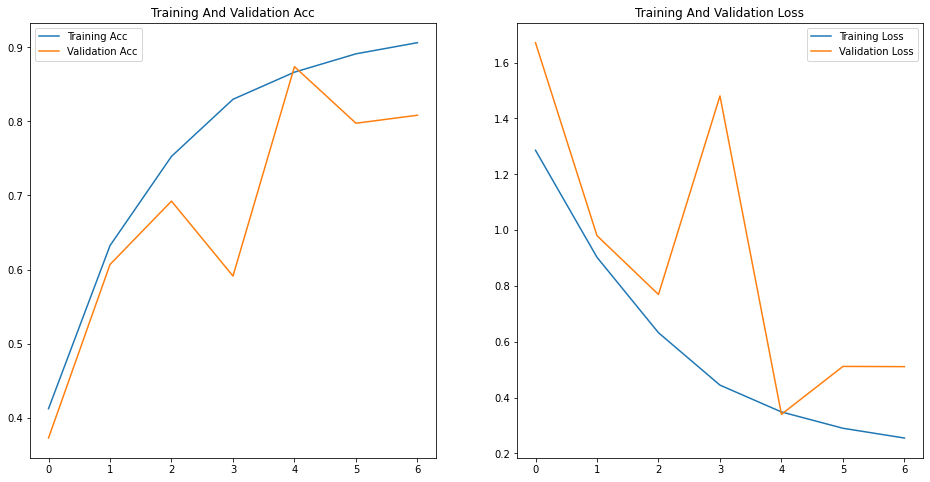

In [14]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')
plt.legend()

plt.show()